### `TEST: Various plots using presupernova model Odrzywolek`
*The following plots are from FluxContainer_demo.ipynb*

In [1]:
import numpy as np
from astropy import units as u
from snewpy.models import presn, ccsn
from snewpy.neutrino import Flavor

import pylab as plt
from contextlib import contextmanager
plt.style.use('seaborn-talk')

/var/folders/4t/p2_knw3504lbc90bf1vzj4h00000gn/T/ipykernel_11225/2834227578.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-talk')


In [2]:
@contextmanager
def raises(exception):
    "A small utility to catch and show the exceptions"
    try:
        yield
    except exception as e:
        print(f'{exception.__name__}: {e}')

### Initializing model

In [3]:
model = presn.Odrzywolek_2010('../../models/presn-models/Odrzywolek_2010/s25_nuebar_data.txt')

times    = model.time #np.linspace(0,2,1500)<<u.second;
energies = np.linspace(0,50,501)<<u.MeV

flux = model.get_flux(t = times, E = energies, distance=0.6<<u.kpc)

In [4]:
from snewpy.flux import Container

Container?

Init signature:
Container(
    data: astropy.units.quantity.Quantity,
    flavor: List[snewpy.neutrino.Flavor],
    time: typing.Annotated[astropy.units.quantity.Quantity, Unit("s")],
    energy: typing.Annotated[astropy.units.quantity.Quantity, Unit("MeV")],
    *,
    integrable_axes: Optional[Set[snewpy.flux.Axes]] = None,
)
Docstring:     
base class for internal use
:noindex:
Init docstring:
A container class storing the physical quantity (flux, fluence, rate...), which depends on flavor, time and energy.

Parameters
----------
data: :class:`astropy.Quantity`
    3D array of the stored quantity, must have dimensions compatible with (flavor, time, energy)

flavor: list of :class:`snewpy.neutrino.Flavor`
    array of flavors (should be ``len(flavor)==data.shape[0]``

time: array of :class:`astropy.Quantity`
    sampling points in time (then ``len(time)==data.shape[1]``) 
    or time bin edges (then ``len(time)==data.shape[1]+1``) 

energy: array of :class:`astropy.Quantity`
    samp

### Calculate rates

In [5]:
from snewpy.rate_calculator import RateCalculator
rc = RateCalculator()

Using snowglobes_data module ...


In [6]:
#calculate time differential rate 
rates = rc.run(flux, 'scint20kt')
rates['ibd']

/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:42: RuntimeWarning: divide by zero encountered in log
  xsecs = np.interp(np.log(E)/np.log(10), xp, yp, left=0, right=0)*E*1e-38 <<u.cm**2
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=ibd. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channel=nue_e. Using 100% efficiency
  warn(f'Efficiency not found for detector={detector}, channel={channel.name}. Using 100% efficiency')
/Users/peterasljung/miniconda3/envs/josef/lib/python3.11/site-packages/snewpy/rate_calculator.py:160: UserWarning: Efficiency not found for detector=scint20kt, channe

Container[cm2 / (s cm2)] (1, 1034, 200) [cm2 / (s cm2)]: <1 flavor(2;2) x 1034 time(-682922300000.0 s;-0.0 s) x 201 energy(0.25 MeV;100.25 MeV)>

In [7]:
#calculate time integral rate 
fluence = flux.integrate('time', np.arange(-172800,0,172.8)<<u.s) #Ida:changed the time in array
ratesI = rc.run(fluence, 'scint20kt')
ratesI['ibd']

Container[cm2 / cm2] (1, 999, 200) [cm2 / cm2]: <1 flavor(2;2) x 1000 time(-172800.0 s;-172.8000000116299 s) x 201 energy(0.25 MeV;100.25 MeV)>

In [8]:
#Utility function to draw the flux
from snewpy.flux import Axes

def project(flux, axis, integrate=True):
    axis = Axes[axis] #convert to enum
    integrate_axis = Axes.time 
    if axis == integrate_axis:
        integrate_axis = Axes.energy 
    fI = (flux.integrate if integrate else flux.sum)(integrate_axis)
    return fI.axes[axis], fI
    
def plot_projection(flux, axis, step=False, integrate=True):
    x,fI = project(flux,axis, integrate)
    y = fI.array.squeeze().T
    if step:
        #we're dealing with bins, not points
        l = plt.step(x[:-1], y, where='pre', label=[Flavor(flv).to_tex() for flv in flux.flavor])
    else:
        l = plt.plot(x, y, label=[Flavor(flv).to_tex() for flv in flux.flavor])
    
    plt.ylabel(f'{fI.__class__.__name__},  {y.unit}')
    plt.xlabel(f'{Axes[axis].name},  {x.unit}')
    return l

In [9]:
#Utility function to draw the 
def plot_rates(rates):
    for ch,r in rates.items():
        rT = r.sum('energy')

        plt.plot(rT.time, rT.array.squeeze(), label=ch)
    #plt.xlim(right=0.5)
    plt.ylabel(f'{rT.__class__.__name__},  {r.array.unit}')
    plt.xlabel(f'time, {rT.time.unit}')

### Plot fluxes

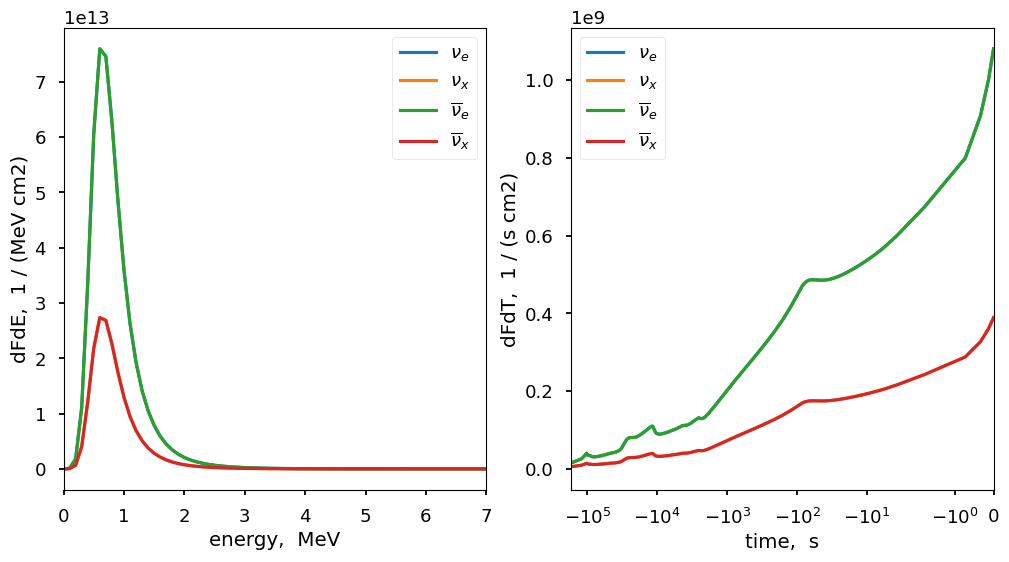

In [10]:
#plot the neutrino flux 
fig,ax = plt.subplots(1,2, figsize=(12,6))
plt.sca(ax[0])
plot_projection(flux, 'energy', integrate=True) #flux [:,1600:,:51]
plt.xlim(0,7) #ida added
plt.legend()

plt.sca(ax[1])
plot_projection(flux, 'time', integrate=True)
plt.xlim(-172000,0) #48 hours
plt.legend()
plt.xscale('symlog')
plt.show()

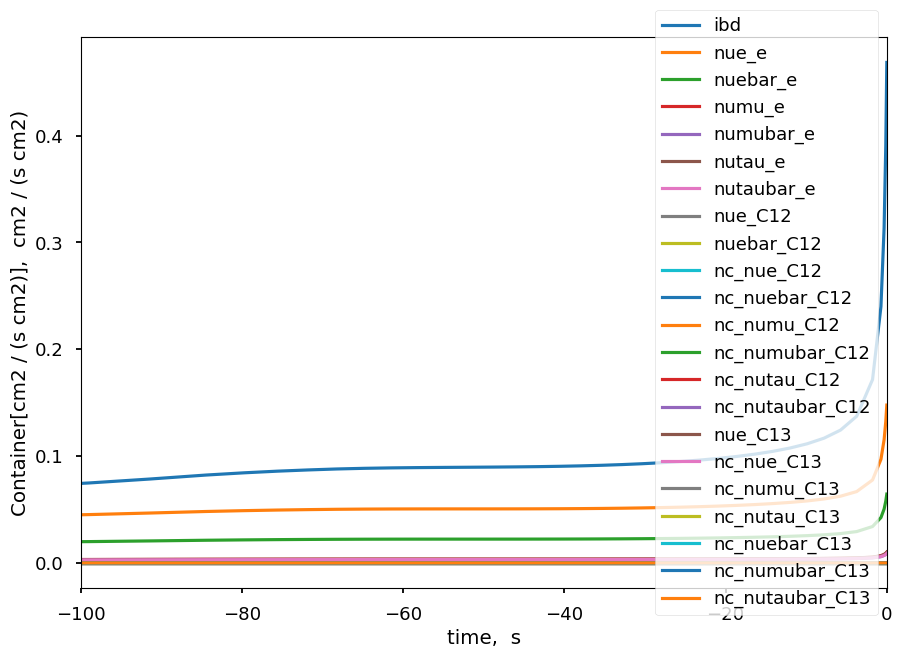

In [11]:
for ch, rate in rates.items():
    l = plot_projection(rate, 'time', integrate=False)
    l[0].set_label(ch)
#plt.yscale('log')
plt.legend(loc='right')
#plt.ylim(0.1)
plt.xlim(-100,0)
plt.show()

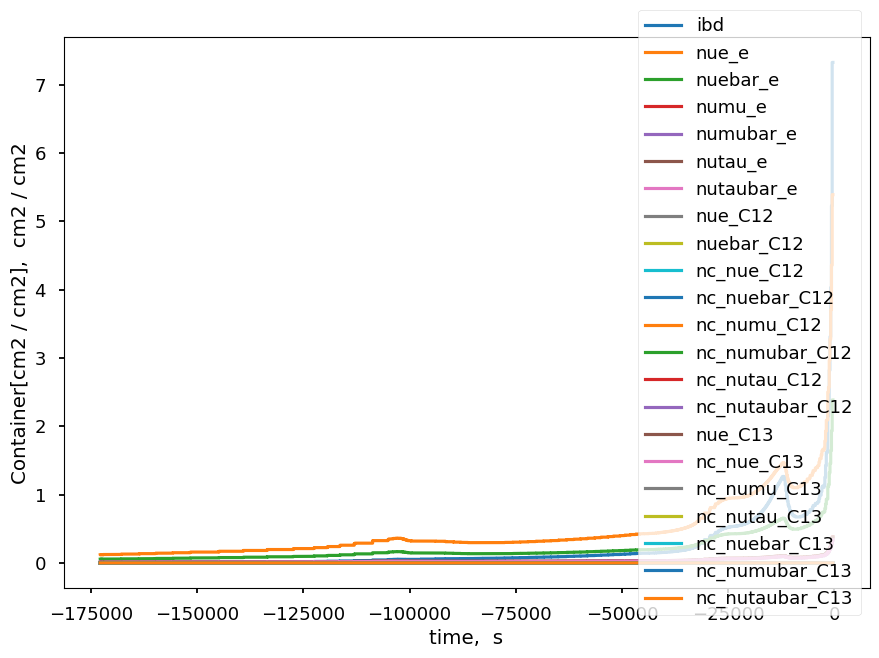

In [12]:
for ch, rate in ratesI.items():
    l = plot_projection(rate, 'time', integrate=False, step=True)
    l[0].set_label(ch)
#plt.yscale('log')
plt.legend(loc='right')
plt.show()